# PCA dimensionality reduction v2

In [1]:
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

from src.feature_selection import analyse_pca, find_n_components, find_max_contributor

## Read in scaled features

In [2]:
df = pd.read_csv("../data/cohort_features_scaled_v2.csv", index_col="ID")
df.head(5)

,n_stays,anchor_age,suspected_infection,weight,height_chart,heart_rate_min,heart_rate_max,temperature_min,temperature_max,nbpm_min,...,dopamine,epinephrine,norepinephrine,phenylephrine,vasopressin,dobutamine,milrinone,albumin,bilirubin,abps
ID,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.909091,1,-1.329023,-1.333333,1.045455,0.571429,0.888889,1.000000,-1.733333,...,0,0,1,1,0,0,0,0,1,1
1,0.0,0.818182,1,-0.521152,0.333333,-0.500000,1.321429,-0.111111,-0.333333,-0.333333,...,0,0,0,1,0,0,0,0,0,1
2,0.0,0.181818,0,-0.922558,-0.466667,0.409091,0.428571,2.111111,0.500000,0.933333,...,0,0,0,0,0,0,0,0,1,1
3,0.0,-0.409091,1,0.986648,0.666667,0.545455,0.107143,0.888889,1.111111,0.333333,...,0,0,0,0,0,0,0,0,0,0
4,0.0,-1.000000,1,0.057344,0.533333,0.590909,0.535714,0.444444,0.111111,1.533333,...,0,0,0,0,0,0,0,1,1,1


## Find number of components required

Target explained variance 90%

In [3]:
# Fit the PCA estimator using maximum number of features
pca = PCA(
    n_components=len(df.columns.values),
    random_state=42
)
pca.fit(df)

# Find the number of components required
explained_variance_required = 90
n_components = find_n_components(pca, explained_variance_required)
n_components

1

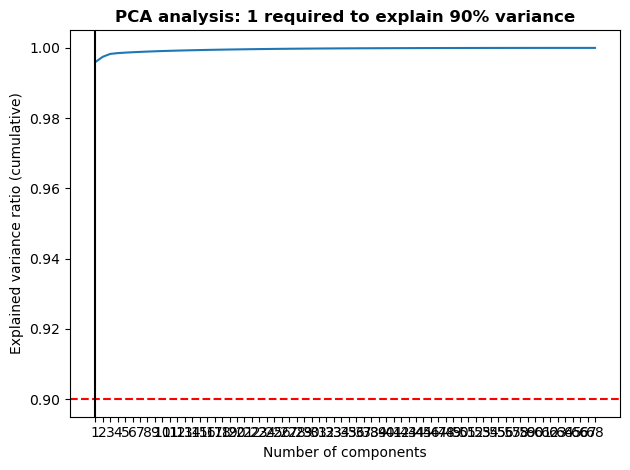

In [4]:
analyse_pca(df, explained_variance_required)

## Find the biggest contributors to each of the components

PCA can be used for feature selection by finding the biggest features to each of the principal components.

In [5]:
# Fit the PCA using the required number of components
pca = PCA(n_components=2, random_state=42)
pca.fit(df)

PCA(n_components=2, random_state=42)

In [6]:
pca.explained_variance_ratio_

array([0.99595296, 0.00150649])

In [7]:
components = pd.DataFrame({
    "PC1": pca.components_[0],
    "PC1_abs": np.abs(pca.components_[0]),
    "PC2": pca.components_[1],
    "PC2_abs": np.abs(pca.components_[1])
})
components["feature_name"] = df.columns
components

,PC1,PC1_abs,PC2,PC2_abs,feature_name
0,-0.000098,0.000098,0.010311,0.010311,n_stays
1,-0.000191,0.000191,0.002561,0.002561,anchor_age
2,-0.000087,0.000087,0.004293,0.004293,suspected_infection
3,-0.000080,0.000080,0.003549,0.003549,weight
4,0.000016,0.000016,0.000577,0.000577,height_chart
...,...,...,...,...,...
63,-0.000009,0.000009,0.001228,0.001228,dobutamine
64,-0.000004,0.000004,0.000572,0.000572,milrinone
65,0.000089,0.000089,0.001836,0.001836,albumin
66,0.000095,0.000095,0.002234,0.002234,bilirubin


### Find max contributor to PC1 and PC2

In [8]:
# PC1
components.sort_values(by="PC1_abs", ascending=False).head(10)

,PC1,PC1_abs,PC2,PC2_abs,feature_name
31,0.999996,0.999996,-0.000428,0.000428,lactate_min
32,0.002666,0.002666,-0.014503,0.014503,lactate_max
15,-0.000479,0.000479,-0.998947,0.998947,spo2_min
13,0.000252,0.000252,-0.012223,0.012223,rr_min
35,0.000252,0.000252,-0.011006,0.011006,ph_min
23,-0.000191,0.000191,-0.003385,0.003385,glucose_max
1,-0.000191,0.000191,0.002561,0.002561,anchor_age
8,0.000168,0.000168,-0.004981,0.004981,temperature_max
38,-0.000147,0.000147,0.010501,0.010501,pco2_max
27,-0.000124,0.000124,-0.000513,0.000513,potassium_max


In [9]:
# PC2
components.sort_values(by="PC2_abs", ascending=False).head(10)

,PC1,PC1_abs,PC2,PC2_abs,feature_name
15,-0.000479,0.000479,-0.998947,0.998947,spo2_min
9,0.000022,0.000022,-0.014971,0.014971,nbpm_min
11,0.000096,0.000096,-0.014828,0.014828,nbps_min
32,0.002666,0.002666,-0.014503,0.014503,lactate_max
13,0.000252,0.000252,-0.012223,0.012223,rr_min
39,0.000095,0.000095,-0.011044,0.011044,po2_min
35,0.000252,0.000252,-0.011006,0.011006,ph_min
38,-0.000147,0.000147,0.010501,0.010501,pco2_max
0,-0.000098,0.000098,0.010311,0.010311,n_stays
7,-0.000017,0.000017,-0.009248,0.009248,temperature_min


## Transform and visualise the dataset by principle components

In [10]:
df_pca = pd.DataFrame(pca.transform(df), columns=["PC1", "PC2"])
df_pca.index.name = "ID"
df_pca.to_csv("../data/cohort_features_pca_v2.csv")
df_pca.head(5)

,PC1,PC2
ID,,
0,-8.616509,-0.329346
1,-9.616819,-0.435717
2,-9.331722,-3.538748
3,-9.757332,-0.521219
4,-7.608936,-3.519949


In [11]:
# Merge in LOS labels
df_lab = pd.read_csv("../data/cohort_labels_v2.csv", index_col="ID")
df_pca = pd.merge(left=df_pca, right=df_lab, on="ID")
df_pca.head(5)

,PC1,PC2,sum_los
ID,,,
0,-8.616509,-0.329346,12.014028
1,-9.616819,-0.435717,6.356898
2,-9.331722,-3.538748,5.166100
3,-9.757332,-0.521219,8.357373
4,-7.608936,-3.519949,6.595347


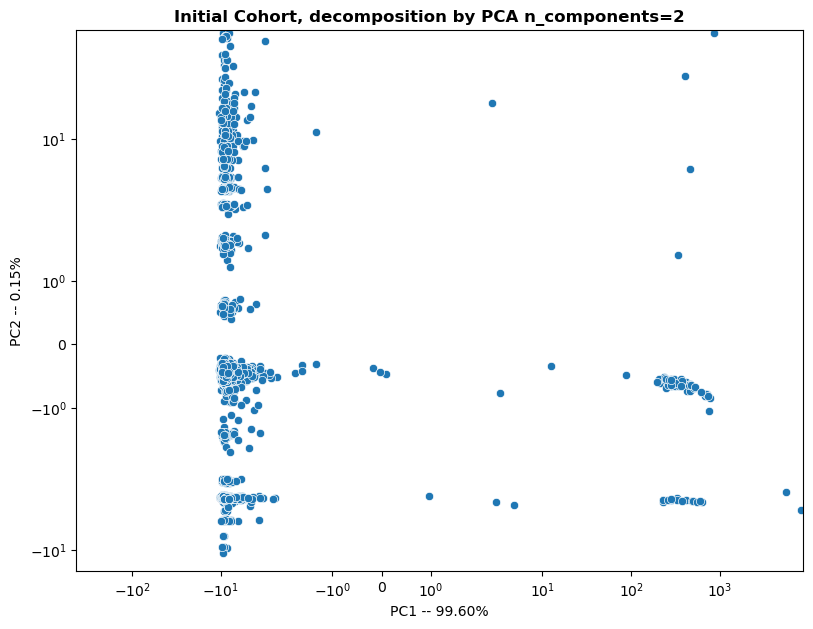

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
fig.tight_layout()

sns.scatterplot(df_pca, x="PC1", y="PC2", ax=ax)

ax.set_xscale("symlog")
ax.set_yscale("symlog")
ax.set_xlabel(f"PC1 -- {(100 * pca.explained_variance_ratio_[0]):.2f}%")
ax.set_ylabel(f"PC2 -- {(100 * pca.explained_variance_ratio_[1]):.2f}%")

fig.suptitle("Initial Cohort, decomposition by PCA n_components=2",
             fontweight="semibold", y=1.0)

plt.show()

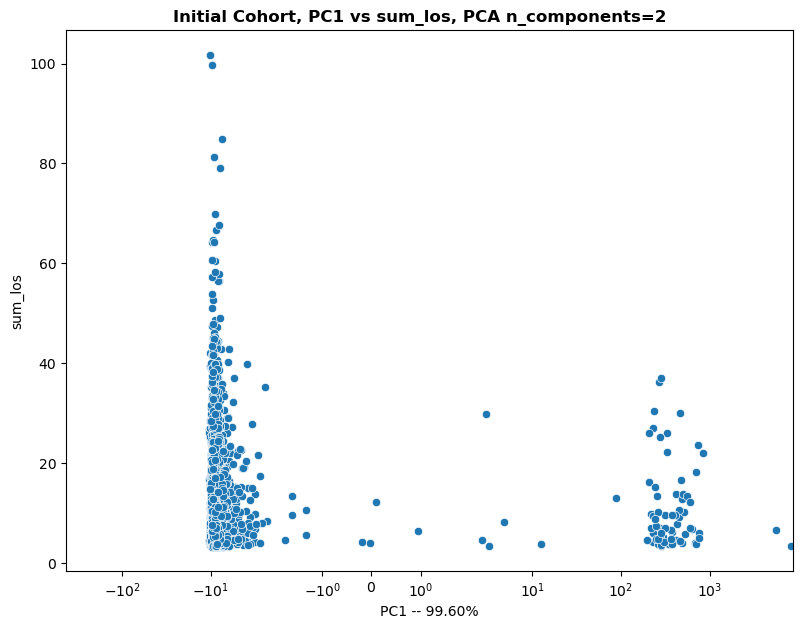

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
fig.tight_layout()

sns.scatterplot(df_pca, x="PC1", y="sum_los", ax=ax)

ax.set_xscale("symlog")
ax.set_xlabel(f"PC1 -- {(100 * pca.explained_variance_ratio_[0]):.2f}%")

fig.suptitle("Initial Cohort, PC1 vs sum_los, PCA n_components=2",
             fontweight="semibold", y=1.0)

plt.show()

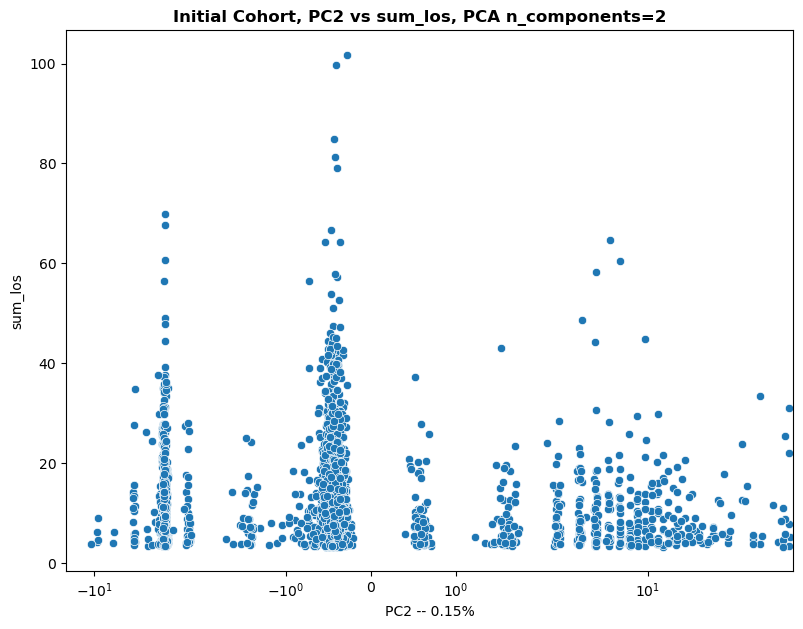

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
fig.tight_layout()

sns.scatterplot(df_pca, x="PC2", y="sum_los", ax=ax)

ax.set_xscale("symlog")
ax.set_xlabel(f"PC2 -- {(100 * pca.explained_variance_ratio_[1]):.2f}%")

fig.suptitle("Initial Cohort, PC2 vs sum_los, PCA n_components=2",
             fontweight="semibold", y=1.0)

plt.show()